# Final code

## [Link for CF Solution](https://www.overleaf.com/4679963215kkhxcqqhzrxh)


## Analysis based on delta coefficients

In [427]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import os
from multiprocessing import Pool
import warnings



# Parametres

In [428]:
N2, NR, N1= 1.0, 1.0, 1.0
P2_max, PR_max, P1 = 10.0, 10.0, 10.0
tau = 0.25

# Functions

In [429]:
def calculate_A(H11): 
    return ((((H11**2)*P1)/(((1+(((H11**2)*P1)))**(1-tau))-1))-1)    

def C(x): 
    return (1/2*np.log2(1+x))

def mult_res_v2(F, hR2, h12, h1R, hR1, h22, h2R, h21, h11):
    # calculer BF ou SA pour plusieurs echantillons 
    all_res = np.zeros((hR2.shape[0], 11))
    for i in range (hR2.shape[0]):
        
        all_res[i][0] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[0]
        all_res[i][1] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[1]
        all_res[i][2] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[2]
        
        all_res[i][3] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[3]
        all_res[i][4] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[4]
        all_res[i][5] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[5]
        
        all_res[i][6] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[6]
        all_res[i][7] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[7]
        all_res[i][8] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[8]
        
        all_res[i][9] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[9]
        all_res[i][10] += F(hR2[i], h12[i], h1R[i], hR1[i], h22[i], h2R[i], h21[i], h11[i])[10]




    return all_res
 

def Delta(HR2, H12, H1R, HR1, H22, H2R, H21, H11):
   
    #A = (((H11**2*P1)/(((1+((H11**2*P1)/(N1)))**(1-tau))-1))-N1)    
    A = calculate_A(H11)
    N2_tilde = ((H12**2)*P1+1)
    NR_tilde = ((H1R**2)*P1+1)
    P_Z = ((H12*H1R*P1)/(np.sqrt(N2_tilde*NR_tilde)))
    K1 = ((H2R**2)*N2_tilde+(H22**2)*NR_tilde-2*H2R*H22*P_Z*np.sqrt(N2_tilde*NR_tilde))
    K2 = ((1-P_Z**2)*NR_tilde*N2_tilde)
    
    C1 = K1*(HR1**2)*((H22**2)*(HR1**2)-(HR2**2)*(H21**2))
    C2 = K1*(HR2**2)*(H21**2)*A-2*(HR1**2)*(H22**2)*K1*A-(HR1**2)*(H22**2)*(H21**2)*K2
    C3 = (H22**2)*K1*(A**2)+(H22**2)*(H21**2)*K2*A
    C4 = K2*(HR2**2)*(H21**2)**2-N2_tilde*K1*(H21**2)*(HR1**2)
    C5 = N2_tilde*(H21**2)*(K1*A+K2*(H21**2))
    D = C1**2*C5**2-C1*C4*(C2*C5-C3*C4)
    
    return C1,C2,C3,C4,C5,D

def f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr, P2):
    # f en fonction de PR et P2
    A = calculate_A(H11)     

    N2_tilde = ((H12**2)*P1+1)
    NR_tilde = ((H1R**2)*P1+1)
    P_Z = ((H12*H1R*P1)/(np.sqrt(N2_tilde*NR_tilde)))
    K1 = ((H2R**2)*N2_tilde+(H22**2)*NR_tilde-2*H2R*H22*P_Z*np.sqrt(N2_tilde*NR_tilde))
    K2 = ((1-P_Z**2)*NR_tilde*N2_tilde)
    #res = (K1*HR2**2*P2*Pr+H22**2*P2*K1*P2+H22**2*P2*K2)/(K2*HR2**2*Pr+N2_tilde*K1*P2+N2_tilde*K2)
    res = (K1*(HR2**2)*P2*Pr+(H22**2)*P2*(K1*P2+K2))/(K2*(HR2**2)*Pr+N2_tilde*K1*P2+N2_tilde*K2)

    
    return res

def f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x):
    'fonction depend seulment de Pr (x apres changement de variable) '
    # f en fonction de PR 
    A = calculate_A(H11)
    N2_tilde = ((H12**2)*P1+1)
    NR_tilde = ((H1R**2)*P1+1)
    P_Z = ((H12*H1R*P1)/(np.sqrt(N2_tilde*NR_tilde)))
    K1 = ((H2R**2)*N2_tilde+(H22**2)*NR_tilde-2*H2R*H22*P_Z*np.sqrt(N2_tilde*NR_tilde))
    K2 = ((1-P_Z**2)*NR_tilde*N2_tilde)


    C1 = K1*(HR1**2)*((H22**2)*(HR1**2)-(HR2**2)*(H21**2))
    C2 = K1*(HR2**2)*(H21**2)*A-2*(HR1**2)*(H22**2)*K1*A-(HR1**2)*(H22**2)*(H21**2)*K2
    C3 = (H22**2)*K1*(A**2)+(H22**2)*(H21**2)*K2*A
    C4 = K2*(HR2**2)*(H21**2)**2-N2_tilde*K1*(H21**2)*(HR1**2)
    C5 = N2_tilde*(H21**2)*(K1*A+K2*(H21**2))

    f = (C1*x**2+C2*x+C3)/(C4*x+C5)
    
    return f

# Bruteforce

In [430]:
def BF_V2(HR2, H12, H1R, HR1, H22, H2R, H21, H11):
    ''' Bruteforce '''
    Pr = np.linspace(0.0, PR_max, 1000)
    P2 = np.linspace(0.0, P2_max, 1000)

    B,C = np.meshgrid(Pr, P2)
              
    A = calculate_A(H11)     
    
    # if QoS constraint respected
    mask = B <= (A-(H21**2)*C)/(HR1**2)
    #mask2 = C <= (A-(HR1**2)*B)/(H21**2)

    B = B[mask]
    C = C[mask]
    
    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, B, C)

    ind = np.argmax(SNR)

    SNR_opt, pr_opt, ps_opt = SNR[ind], B[ind], C[ind]
    
    #P2_opt = (A-(HR1**2)*pr_opt)/(H21**2)
    
    #SNR_opt = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, pr_opt, ps_opt)
    #SNR_opt = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, pr_opt, ps_opt)


    
    return pr_opt, ps_opt, SNR_opt

In [431]:


def CF_V4(HR2, H12, H1R, HR1, H22, H2R, H21, H11):
    '''
    Version Finale
    '''
        
    A = calculate_A(H11)
    #x_min, x_max = f_domain(HR2, H12, H1R, HR1, H22, H2R, H21, H11)
    if ( (A/(HR1**2)) < PR_max and (A/(H21**2)) < P2_max ) :  # H1

        x_min, x_max = 0.0, A/(HR1**2)        

    elif ( (A/(HR1**2)) < PR_max and (A/(H21**2)) > P2_max ):# H2

        x_min, x_max =  (A-(H21**2)*P2_max)/(HR1**2), A/(HR1**2)

    elif ( (A/(HR1**2)) > PR_max and (A/(H21**2)) < P2_max ):# H3

        x_min, x_max =  0.0 , PR_max
        
    elif ( (A/(HR1**2)) > PR_max and (A/(H21**2)) > P2_max ) and P2_max*(H21**2) + PR_max*(HR1**2) > A: #H4

        x_min, x_max =  (A-(H21**2)*P2_max)/(HR1**2), PR_max
        
    C1, C2, C3, C4, C5, delta = Delta(HR2, H12, H1R, HR1, H22, H2R, H21, H11)

    try :
        if C1*C4>0:
            #print('C1*C4>0')
            
            if delta > 0 :
                x_1 = (-(C1*C5)-np.sqrt(delta))/(C1*C4) 
                x_2 = (-(C1*C5)+np.sqrt(delta))/(C1*C4) 
                if (x_1 <= x_min <= x_max <= x_2): 
                    Pr_opt = x_min 
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt,P2_opt)
                elif (x_1<=x_min<=x_2<=x_max and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_min)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max)): 
                    Pr_opt = x_min 
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt,P2_opt)
                      
                elif x_1 >= x_max :
                    Pr_opt = x_max 
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
               
                elif x_2 <= x_max :
                    Pr_opt = x_max 
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)

                elif  (x_1 <= x_min <= x_2 <= x_max and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_min)):
                    Pr_opt = x_max 
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                    
                elif (x_min <= x_1 <= x_2<=x_max and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_1)): 
                    Pr_opt = x_max 
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)

                elif (x_min <= x_1 <= x_max <=x_2) :
                    Pr_opt = x_1
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                elif (x_min<=x_1<=x_2<=x_max and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_1)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max)):
                    Pr_opt = x_1
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


            elif delta == 0 :
                
                x_0 = -C5/C4
                Pr_opt = x_max
                P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                
            else :
                    Pr_opt = x_max
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                    


        elif C1*C4 == 0.0 : 
            #print('C1*C4 == 0')
            x_ = -(C2*C5-C3*C4)/(2*C1*C5)

            if (C1*C5)>0.0 :
                
                if (C2*C5-C3*C4)>0.0 :

                    Pr_opt = x_max
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)

                else : 

                    if x_ < x_min : 

                        Pr_opt = x_max
                        P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                        SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)

                    elif (x_min <= x_ <= x_max) : 

                        if f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_min)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max) :
                            
                            Pr_opt = x_min
                            P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                            SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


                        else : 
                            
                            Pr_opt = x_max
                            P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                            SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


                    elif x_ > x_max :

                        Pr_opt = x_min
                        P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                        SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


            elif (C1*C5) == 0.0 : 
                #print('C1*C5')
                if (C2*C5-C3*C4) > 0.0 :
                    
                    Pr_opt = x_max
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)

                else :
                    
                    Pr_opt = x_min
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


            else :
                if (C2*C5-C3*C4)>0.0 :
                    #print((C2*C5-C3*C4))
                    if x_ < x_min :
                        
                        Pr_opt = x_min
                        P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                        SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


                    elif (x_min <= x_ <= x_max):
                        
                        Pr_opt = x_
                        P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                        SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)

                    elif x_ > x_max :
                        
                        Pr_opt = x_max  #     x_    
                        P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                        SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                
                else : # (C2*C5-C3*C4) < 0 ...
                        Pr_opt = x_min        
                        P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                        SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


        else :
            #print('C1*C4<0')

            if delta > 0.0 :
                #print('delta>0')
                x_1 = (-(C1*C5)-np.sqrt(delta))/(C1*C4) 
                x_2 = (-(C1*C5)+np.sqrt(delta))/(C1*C4)
                
                if x_1 <= x_min  : 
                    
                    Pr_opt = x_min
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                
                elif (x_min<=x_2<=x_max and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_min)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11,x_max)): 
                    Pr_opt = x_min
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


                elif  x_max <= x_2:
                    Pr_opt = x_min
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                elif  (x_min<=x_2<=x_max<=x_1 and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11,x_min)):
                    Pr_opt = x_min
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)


                elif (x_min <= x_1 <= x_max) :
                    
                    Pr_opt = x_1
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                elif (x_min <= x_2 <= x_max <= x_1 and f(HR2, H12, H1R, HR1, H22, H2R, H21, H11, x_max)>f(HR2, H12, H1R, HR1, H22, H2R, H21, H11,x_min)) :
                    
                    Pr_opt = x_max
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                elif (x_2 <= x_min <= x_max <= x_1) :
                    
                    Pr_opt = x_max
                    P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                    SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
               
                
            elif delta == 0 :
                #print('delta=0')


                x_0 = -C5/C4
                Pr_opt = x_min
                P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                
            else :
            
                Pr_opt = x_min
                P2_opt = (A-(HR1**2)*Pr_opt)/(H21**2)
                SNR = f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt)
                

     

    except UnboundLocalError:
        
        Pr_opt, P2_opt, SNR = PR_max, P2_max ,f_obj(HR2, H12, H1R, HR1, H22, H2R, H21, H11, PR_max, P2_max)
        #print('[H5]-[H6]')
    
    
    return HR2, H12, H1R, HR1, H22, H2R, H21, H11, Pr_opt, P2_opt, SNR
            
    

# Analytic soluton

# Phase test

## Dataset creation

In [432]:
Nbr = 10000
pos_min = 0 # min position in cell
pos_max = 10 # max position in cell

#-----------------------------------------------------------------------------------------------------------#
#-----------------------------------------------------------------------------------------------------------#

def channel_gain_with_gaussian_fading(d, sigma=7, alpha=3):  # channel gain model
  """
      channel gain model.
      Args:
         d: distance between source and destination
         sigma: gaussian fading sigma
         alpha: is the path loss factor
      Returns:
        channel gain
  """    
  s = np.random.normal(0.0, sigma, d.shape[0])
  h = s/np.sqrt(1.0 + np.power(d, alpha))

  return h


#-----------------------------------------------------------------------------------------------------------#
def gain_model_2(d): 
  """
      Channel gain model from reference [2].
      [2] : Savard, Anne, and E. Veronica Belmega. "Optimal power allocation in a relay-aided cognitive network." Proceedings of the 12th EAI International Conference on Performance Evaluation Methodologies and Tools. 2019.
      
      Args:
         d: distance between source and destination
      Returns:
        channel gain
  """      
  return 1/d**(3/2) #(1/d**(3/2))**2
#-----------------------------------------------------------------------------------------------------------#

U_1 = np.random.uniform(pos_min, pos_max, (Nbr, 2))
D_1 = np.random.uniform(pos_min, pos_max, (Nbr, 2))
U_2 = np.random.uniform(pos_min, pos_max, (Nbr, 2))
D_2 = np.random.uniform(pos_min, pos_max, (Nbr, 2))
R  = 5 * np.ones((Nbr, 2))

d_11 = np.linalg.norm(U_1 - D_1, axis=1)
d_12 = np.linalg.norm(U_1 - D_2, axis=1)
d_1R = np.linalg.norm(U_1 - R  , axis=1)
d_21 = np.linalg.norm(U_2 - D_1, axis=1)
d_22 = np.linalg.norm(U_2 - D_2, axis=1)
d_2R = np.linalg.norm(U_2 - R  , axis=1)
d_R1 = np.linalg.norm(R   - D_1, axis=1)
d_R2 = np.linalg.norm(R   - D_2, axis=1)

var  = 7
'''
h_R2 = channel_gain_with_gaussian_fading(d_R2, var)
h_12 = channel_gain_with_gaussian_fading(d_12, var)
h_1R = channel_gain_with_gaussian_fading(d_1R, var)
h_R1 = channel_gain_with_gaussian_fading(d_R1, var)
h_22 = channel_gain_with_gaussian_fading(d_22, var)
h_2R = channel_gain_with_gaussian_fading(d_2R, var)
h_21 = channel_gain_with_gaussian_fading(d_21, var)
h_11 = channel_gain_with_gaussian_fading(d_11, var)
'''
#-----------------------------------------------------------------------------------------------------------#


h_R2 = gain_model_2(d_R2)
h_12 = gain_model_2(d_12)
h_1R = gain_model_2(d_1R)
h_R1 = gain_model_2(d_R1)
h_22 = gain_model_2(d_22)
h_2R = gain_model_2(d_2R)
h_21 = gain_model_2(d_21)
h_11 = gain_model_2(d_11)

x_test = np.stack([h_R2, h_12, h_1R, h_R1, h_22, h_2R, h_21, h_11], axis=1)



#CF_res = mult_res_v2(CF_V4, h_R2, h_12, h_1R, h_R1, h_22, h_2R, h_21, h_11)

#BF_res = mult_res_v2(BF_V2, h_R2, h_12, h_1R, h_R1, h_22, h_2R, h_21, h_11)

In [433]:
CF_res = mult_res_v2(CF_V4, h_R2, h_12, h_1R, h_R1, h_22, h_2R, h_21, h_11)



In [434]:
np.max(CF_res[:,9])

10.000000000000057

In [435]:
CF_res_pd = pd.DataFrame({'Pr': CF_res[:, 8], 'P2': CF_res[:, 9], 'SNR': CF_res[:, 10] })
CF_res_pd.describe()

,Pr,P2,SNR
count,10000.000000,10000.000000,1.000000e+04
mean,6.739823,8.688782,1.610516e+03
std,4.160777,2.889077,1.603380e+05
min,0.000000,0.000165,3.316671e-07
25%,2.132788,10.000000,2.114138e-02
50%,10.000000,10.000000,6.410904e-02
75%,10.000000,10.000000,2.289624e-01
max,10.000000,10.000000,1.603379e+07


In [436]:
def noise_to_channels(X, channelID, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    '''
    Parameters : 
       
        test_set :  test set containing the H channels
    
        col : list of index for the specific column to add noise
    
    Returns:
    
        channel gain ndarray container of noisy channels 

    '''    
    
    var_X = np.var(X[:, channelID], axis=0, keepdims=True)
    
    noisy_gains = [] # list to store all the noisy H matrices with different level of noise variance
    for SNR_db in SNRs_db:
        
        SNR = np.power(10,SNR_db/10)
        noises = np.sqrt(var_X/SNR)*np.random.normal(0.0, 1.0, (X.shape[0], len(channelID)))
    
        X_noised = X.copy()
        X_noised[:, channelID] = X_noised[:, channelID] + noises
        noisy_gains.append(X_noised)

    return SNRs_db, np.asarray(noisy_gains, dtype="float64")



#-----------------------------------------------------------------------------------------#

def cf_solution_squeeze(x):
    return CF_V4(x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7])

def generate_benchmark(H_matrix): 
    '''
    bruteforce for H without noise
    '''
    with Pool() as p:
        # remove power since the analytic solution is coded with H 
        BF_res =  p.map(cf_solution_squeeze, H_matrix) 

    return np.squeeze(np.asarray(BF_res, dtype="float64"))

#-----------------------------------------------------------------------------------------#

def cf_solution_for_noisy_channels(BH_matrix):
    
    '''
    Compute bruteforce method for channel gain ndarray composed of noisy channels
    '''

    BF_res = [] # list containing channels and bruteforce results (Alpha,Pr,Ps) for each noisy matrix (0, 10^-1.5, 10^-1....) 
    
    
    for i in range(BH_matrix.shape[0]) :
        X = BH_matrix[i,:,:]
        
        temp_BF_res = generate_benchmark(X)
        
        BF_res.append(temp_BF_res)

        
    return np.asarray(BF_res, dtype="float64")


#-----------------------------------------------------------------------------------------#


In [437]:
Primary_index = [3, 6, 7] 
Secondary_index = [1, 2]

In [438]:
# Get Noisy H-MATRIX with different noise variance

noise_levels, NH_MATRIX = noise_to_channels(x_test, Secondary_index)

# Compute bruteforce for NH-MATRIX

BF_NG_MATRIX = cf_solution_for_noisy_channels(NH_MATRIX) 


# bruteforce for test_set without noise

BF_G_Benchmark = generate_benchmark(x_test) 

#----------------------------------Save data----------------------------------------------#

path_noised_X= 'Imperfect CSI Data/NH_MATRIX_S_Anne'
np.savez(path_noised_X, NH_MATRIX)


outfile_BF_NG_MATRIX = 'Imperfect CSI Data/BF_NH_MATRIX_S_Anne'
np.savez(outfile_BF_NG_MATRIX, BF_NG_MATRIX)


outfile_BF_G_Benchmark = 'Imperfect CSI Data/BF_H_Benchmark_S_Anne'
np.savez(outfile_BF_G_Benchmark, BF_G_Benchmark)

In [439]:
# First, load ... 
# useful for DNN prediction because DNN takes H as input 

outfile_NH_MATRIX = 'Imperfect CSI Data/NH_MATRIX_S_Anne'

NH_MATRIX = np.load(outfile_NH_MATRIX+".npz")
NH_MATRIX.files
NH_MATRIX = NH_MATRIX['arr_0']

# Noisy_H ==> NH_MATRIX

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation ...  because it containing (Alpha, Pr, Ps) 


outfile_BF_NG_MATRIX = 'Imperfect CSI Data/BF_NH_MATRIX_S_Anne'

dataset_test = np.load(outfile_BF_NG_MATRIX+".npz")
dataset_test.files
dataset_test = dataset_test['arr_0']

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation, because it containing G Matrix without noise 


outfile_BF_G_Benchmark = 'Imperfect CSI Data/BF_H_Benchmark_S_Anne'

dataset = np.load(outfile_BF_G_Benchmark+".npz")
dataset.files
dataset = dataset['arr_0']






In [440]:
#-----------------------------------------------------------------------------------------#

def relative_avreage_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return (np.mean(X) - np.mean(Y))/(np.mean(Y))

def avreage_relative_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return np.mean((X-Y)/Y)

#-----------------------------------------------------------------------------------------#

#def opportunistic_rate_CF(dataset, labels=None):
#    '''
#    dataset : test samples
#    labels : For DNN estimations
#    '''
#    final_rate = []
#    for i in dataset : 
#        x_test , y_test = i[:,0:8], i[:,8:11]
#        temp_rate = C(y_test[:,2])
#        final_rate.append(temp_rate)
#    return np.asarray(final_rate, dtype="float64")





In [441]:

def opportunistic_rate_CF(datas, labels):
    
    #dataset : test samples
    #labels : For DNN estimations
    
    final_rate, H_matrix = [], []
    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    for i,j in zip (H_matrix, labels) : 
        x_test , y_test = i[:,0:8], j[:,8:11]
        #temp_rate = C(y_test[:,2])
        temp_rate = C(f_obj(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3], x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], y_test[:,1]))
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")


## GAP AND NOISY DATA

# GAP Secondary Rate

In [442]:
db_cf_solution = opportunistic_rate_CF(dataset, dataset_test)



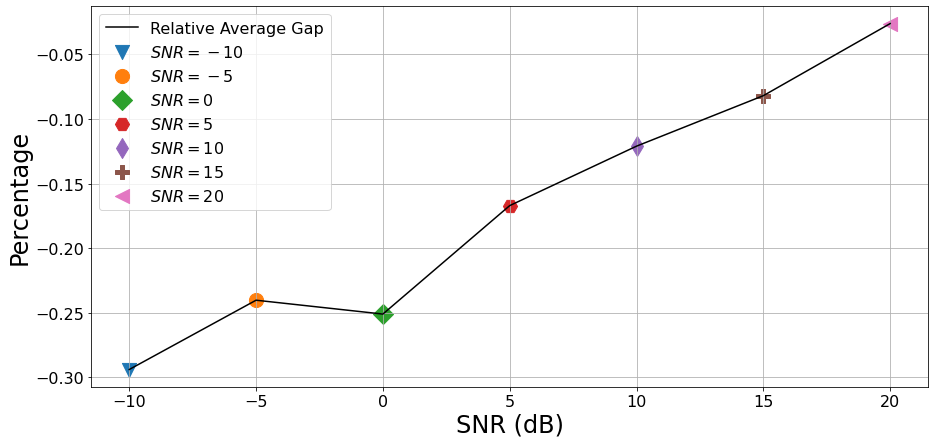

In [443]:
# dataset : channel gain without noise and bruteforce output parameters (Alpha,Pr,Ps)
# dataset_test : channel gain with noise and bruteforce output parameters (Alpha,Pr,Ps)
# Getting only (Alpha,Pr,Ps) from dataset_test to calculate rate in opportunistic_rate_for_noisy_channels function


db_cf_solution = opportunistic_rate_CF(dataset, dataset_test)
db_benchmark = C(dataset[:,-1])



# List of relative gap between each noisy matrix and benchmark (BF results without noise)

db_gap = np.array([relative_avreage_gap(db_cf_solution[0,:], db_benchmark[:]),\
                   relative_avreage_gap(db_cf_solution[1,:], db_benchmark[:]),\
                   relative_avreage_gap(db_cf_solution[2,:], db_benchmark[:]),\
                   relative_avreage_gap(db_cf_solution[3,:], db_benchmark[:]),\
                   relative_avreage_gap(db_cf_solution[4,:], db_benchmark[:]),\
                   relative_avreage_gap(db_cf_solution[5,:], db_benchmark[:]),\
                   relative_avreage_gap(db_cf_solution[6,:], db_benchmark[:])])

db_gap = db_gap*100


# list of variance

#variance = [10**i for i in np.arange(-1.5,2,0.5)]
#varience = variance.insert(0, 0)
SNRs_db = [-10, -5, 0, 5, 10, 15, 20]


def plot_CSI_Imperfect_Stats(res_stats, plot_lab, x_lab, y_lab, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, res_stats, c = 'black',label= plot_lab)

    ax.grid()

    ax.scatter(SNRs_db[0],res_stats[0],label=r'$SNR=-10$',s=200,marker='v',linewidths=1)

    ax.scatter(SNRs_db[1],res_stats[1],label=r'$SNR=-5}$',s=200,marker='o',linewidths=1)

    ax.scatter(SNRs_db[2],res_stats[2],label=r'$SNR=0$',s=200,marker='D',linewidths=1)

    ax.scatter(SNRs_db[3],res_stats[3],label='$SNR=5$',s=200,marker='H',linewidths=1)

    ax.scatter(SNRs_db[4],res_stats[4],label='$SNR=10$',s=200,marker='d',linewidths=1)

    ax.scatter(SNRs_db[5],res_stats[5],label='$SNR=15$',s=200,marker='P',linewidths=1)

    ax.scatter(SNRs_db[6],res_stats[6],label='$SNR=20$',s=200,marker='<',linewidths=1)

    #ax.scatter(var[7],res_stats[7],label='$\sigma=10^{1.5}$',s=200,marker='>',linewidths=1)

    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(loc='best', fontsize=16)

    plt.xlabel(x_lab, fontsize=24) #'Noise variance','Percentage'
    plt.ylabel(y_lab, fontsize=24)
    #plt.xscale('log')
    

plot_CSI_Imperfect_Stats(db_gap, 'Relative Average Gap', 'SNR (dB)','Percentage')





# GAP Primary Rate

In [444]:
def primary_rate_CF(hR2, h12, h1R, hR1, h22, h2R, h21, h11, PR, PS):

    R_P = C((h11**2*P1)/(hR1**2*PR+h21**2*PS+1))

    return R_P

In [445]:
def mean_max_outage_PARD(N_P_Rate, Max_P_Rate, tau = 0.25):
    '''
    N_PRate : Primary rate based on bruteforce output (Alpha, Pr, Ps) where BF is computed using noisy channels 
    Max_P_Rate : Primary rate without secondary users interference
    '''
    res = 1-(N_P_Rate/Max_P_Rate) # Compute of Delta
    #res = np.round(res,4)
    mean_res = np.nanmean(res) # Mean of Delta 
    max_res = np.max(res) # Max of Delta
    #res =  # Outage
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            mean_outage = np.nanmean(res[res>tau])
        except RuntimeWarning:
            mean_outage = 0
            
    outage = np.nanmean(res>tau)
    
    return mean_res, max_res, mean_outage, outage


def PARD_for_noisy_data(datas, labels, Pp=10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j[:,8:11]
        
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1])
        
        P_Rate_max = C((data[:,-1]**2*Pp)) # data[:,1] tend for G_PP
        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100, P_Rate_max


Mean_ARPD, Max_ARPD, Mean_Outage_ARPD, Outage_ARPD,sd= PARD_for_noisy_data(dataset,dataset_test)



Mean_ARPD


array([18.53511496, 18.53511496, 18.53511496, 18.53511496, 18.53511496,
       18.53511496, 18.53511496])

In [446]:
Mean_Outage_ARPD

array([25., 25., 25., 25., 25., 25., 25.])

In [447]:
def plot_ARPD(mean_ARPD, maximum_ARPD, mean_outage_ARPD, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, maximum_ARPD, c = 'blue',label=r"$Max$",lw=2.5)
    ax.plot(SNRs_db, mean_ARPD, c = 'red',label=r"$Mean$",lw=2.5)
    ax.plot(SNRs_db, mean_outage_ARPD, c = 'gray',label=r"$Mean\; outage$",lw=2.5)

    ax.grid()

    xs = np.linspace(1, 10**1.5, 20)

    plt.hlines(y=25, xmin=-10, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')


    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)



    ax.legend(loc='upper center', fontsize=16)

    plt.xlabel('SNR (dB)', fontsize=24)
    plt.ylabel('Primary network degradation (%)', fontsize=24)
    #plt.xscale('log')

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/PDD.pdf', bbox_inches='tight')



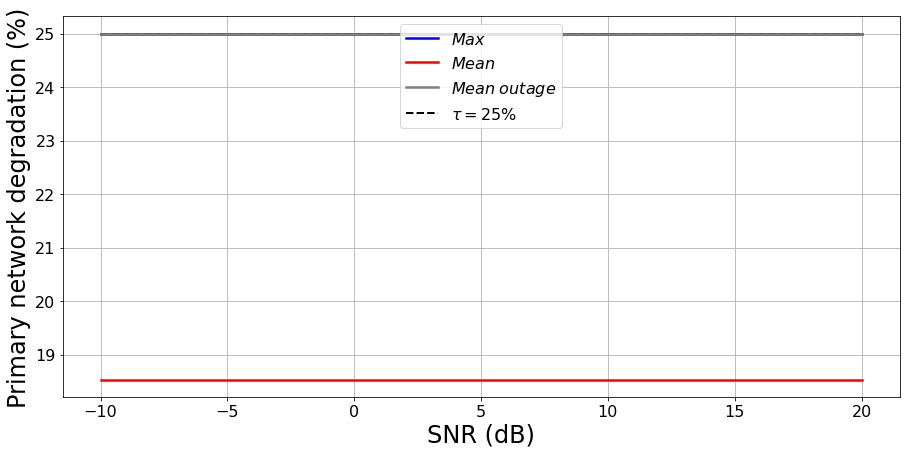

In [448]:
plot_ARPD(Mean_ARPD, Max_ARPD, Mean_Outage_ARPD)

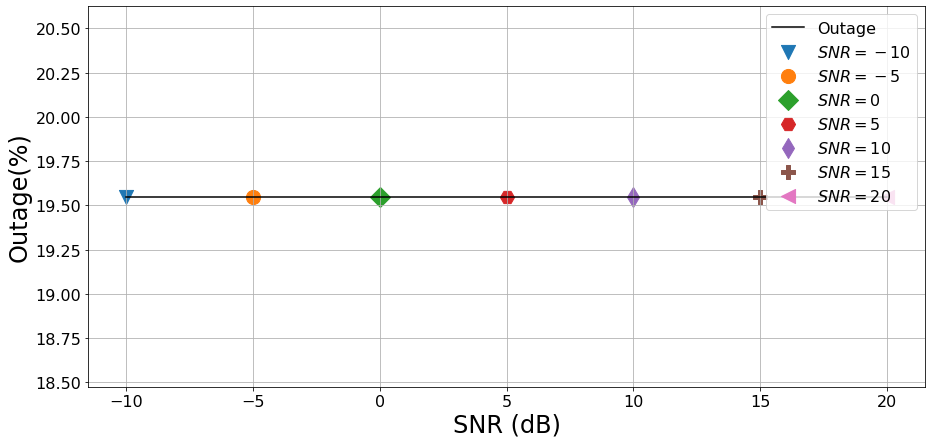

In [449]:

plot_CSI_Imperfect_Stats(Outage_ARPD, 'Outage', 'SNR (dB)','Outage(%)')

